In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.preprocessing import OneHotEncoder

In [40]:

with open('../data/train (6).csv', 'r') as f:
    df=pd.read_csv(f)

with open('../data/train_churn_labels.csv') as f:
    df_label = pd.read_csv(f)

df_combined = pd.concat([df, df_label], axis=1)

In [41]:
# Calculate fill rate for each column
fill_rates = (df_combined.notnull().sum() / len(df)) * 100
fill_rates = fill_rates.sort_values(ascending=False)
fill_rates


Var57     100.0
Var73     100.0
Var212    100.0
Var211    100.0
Var210    100.0
          ...  
Var175      0.0
Var185      0.0
Var169      0.0
Var209      0.0
Var230      0.0
Length: 231, dtype: float64

In [42]:
# Create a summary DataFrame
# Create a summary DataFrame
fill_rate_df = pd.DataFrame({
    'Field': fill_rates.index,
    'FillRate_Percentage': fill_rates.values
})
#print(fill_rate_df)

# Save to CSV if needed
fill_rate_df.to_csv('../data-analysis/fillrate_analysis.csv', index=False)



In [43]:
len(fill_rate_df.loc[fill_rate_df['FillRate_Percentage']>70,:]['Field'].to_list())

68

In [44]:
fill_rate_df.loc[fill_rate_df['FillRate_Percentage']>70,:]['Field'].to_list()

['Var57',
 'Var73',
 'Var212',
 'Var211',
 'Var210',
 'Var204',
 'Var113',
 'Var220',
 'Var195',
 'Var198',
 'Var196',
 'Var228',
 'Label',
 'Var226',
 'Var227',
 'Var216',
 'Var222',
 'Var221',
 'Var207',
 'Var193',
 'Var202',
 'Var199',
 'Var208',
 'Var203',
 'Var197',
 'Var192',
 'Var218',
 'Var217',
 'Var205',
 'Var112',
 'Var83',
 'Var44',
 'Var85',
 'Var78',
 'Var35',
 'Var25',
 'Var76',
 'Var38',
 'Var22',
 'Var123',
 'Var132',
 'Var134',
 'Var133',
 'Var143',
 'Var163',
 'Var160',
 'Var153',
 'Var181',
 'Var173',
 'Var28',
 'Var219',
 'Var223',
 'Var81',
 'Var21',
 'Var6',
 'Var206',
 'Var144',
 'Var119',
 'Var13',
 'Var140',
 'Var7',
 'Var74',
 'Var125',
 'Var65',
 'Var24',
 'Var109',
 'Var149',
 'Var126']

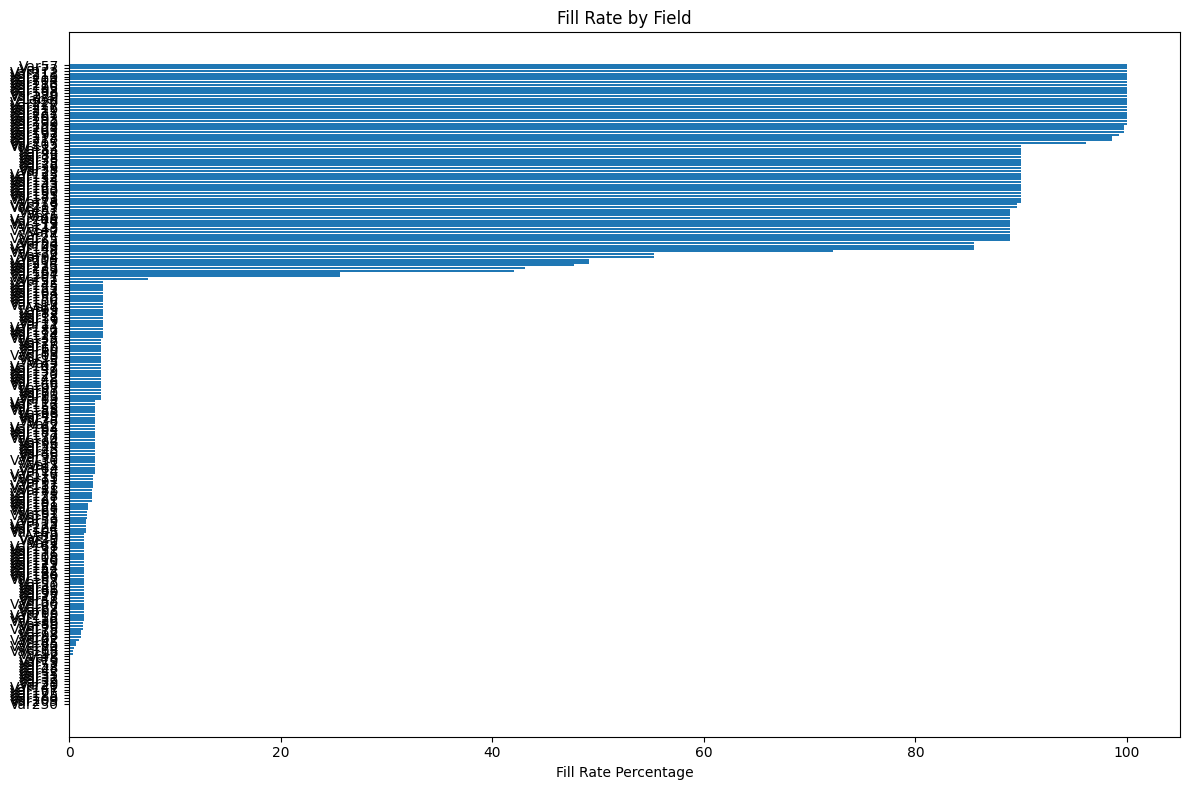

In [45]:
plt.figure(figsize=(12, 8))
plt.barh(fill_rate_df['Field'], fill_rate_df['FillRate_Percentage'])
plt.xlabel('Fill Rate Percentage')
plt.title('Fill Rate by Field')
plt.gca().invert_yaxis()  # Highest fill rates on top
plt.tight_layout()
plt.savefig('../data-analysis/fillrate_plot.png')
plt.show()


*** CLEARLY A LOT OF THE FIELDS HAVE 100% MISSING INFORMATION***

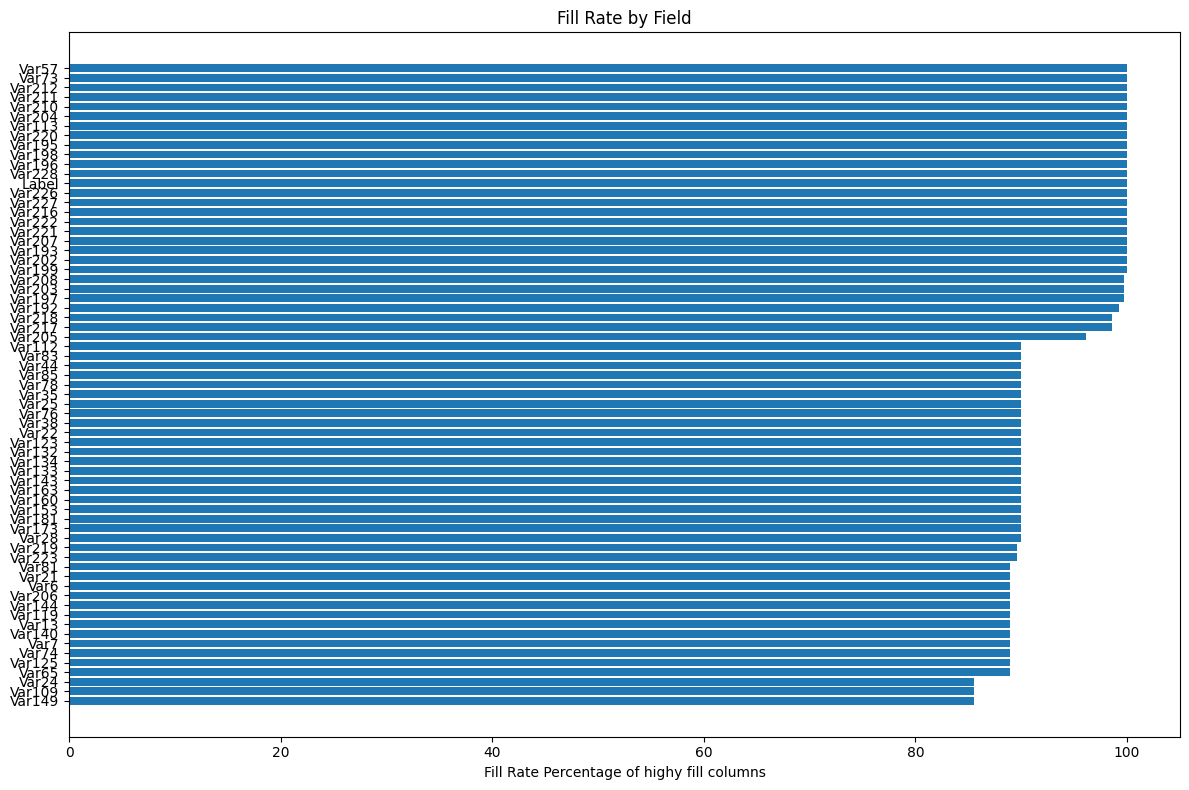

In [46]:
high_fill_fields = fill_rate_df[fill_rate_df['FillRate_Percentage'] > 80]
high_fill_fields
plt.figure(figsize=(12, 8))
plt.barh(high_fill_fields['Field'], high_fill_fields['FillRate_Percentage'])
plt.xlabel('Fill Rate Percentage of highy fill columns')
plt.title('Fill Rate by Field')
plt.gca().invert_yaxis()  # Highest fill rates on top
plt.tight_layout()
plt.savefig('../data-analysis/fillrate_plot_high_fill.png')
plt.show()

**HIGH CARDINAL VALUES** **HIGH CARDINALITY TREATMENTS**

In [47]:
categorical_fields = df_combined.select_dtypes(include=['object']).columns.tolist()
len(categorical_fields)

38

***FOR ENCODING TRAIN TEST SPLIT***

In [48]:
X_train, X_test = train_test_split(df_combined, test_size=0.3, random_state=42)
uniques_ = {i:X_train[i].nunique() for i in X_train.select_dtypes(include=['object']).columns}
uniques_
X_train.to_csv('../data/X_train.csv',index=False)
X_test.to_csv('../data/X_test.csv',index=False)

In [49]:
ser = X_train.isnull().sum()/X_train.shape[0]<0.3
filter_cols=ser[ser].index.tolist()


In [50]:
##OHE Variables -
ohe_vars = [i for i,j in uniques_.items() if j < 5 if i in filter_cols]
print(ohe_vars)
freq_vars = [i for i,j in uniques_.items() if j >= 5 if i in filter_cols]
print(freq_vars)

['Var196', 'Var205', 'Var208', 'Var211', 'Var218', 'Var223']
['Var192', 'Var193', 'Var195', 'Var197', 'Var198', 'Var199', 'Var202', 'Var203', 'Var204', 'Var206', 'Var207', 'Var210', 'Var212', 'Var216', 'Var217', 'Var219', 'Var220', 'Var221', 'Var222', 'Var226', 'Var227', 'Var228']


In [51]:
def fit_ohe_encoder(X_train, categorical_cols):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(X_train[categorical_cols])
    feature_names = ohe.get_feature_names_out(categorical_cols)
    return ohe, feature_names

def transform_ohe_encoder(X, ohe, categorical_cols, feature_names):
    X_ohe = ohe.transform(X[categorical_cols])
    X_ohe_df = pd.DataFrame(X_ohe, columns=feature_names, index=X.index)
    X_dropped = X.drop(columns=categorical_cols)
    X_transformed = pd.concat([X_dropped, X_ohe_df], axis=1)
    return X_transformed

def save_ohe_encoder(ohe, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(ohe, f)

# --- Load Encoder ---
def load_ohe_encoder(filepath):
    with open(filepath, 'rb') as f:
        ohe = pickle.load(f)
    return ohe


In [52]:
ohe, feature_names = fit_ohe_encoder(X_train, ohe_vars)
print(feature_names)
X_train_encoded = transform_ohe_encoder(X_train.loc[:,ohe_vars], ohe, ohe_vars, feature_names)

X_test_encoded = transform_ohe_encoder(X_test.loc[:,ohe_vars], ohe, ohe_vars, feature_names)
# 4. (Optional) Save Encoder
save_ohe_encoder(ohe, '../model-objects/ohe_encoder_eda.pkl')


['Var196_1K8T' 'Var196_JA1C' 'Var196_mKeq' 'Var196_z3mO' 'Var205_09_Q'
 'Var205_VpdQ' 'Var205_sJzTlal' 'Var205_nan' 'Var208_kIsH' 'Var208_sBgB'
 'Var208_nan' 'Var211_L84s' 'Var211_Mtgm' 'Var218_UYBR' 'Var218_cJvF'
 'Var218_nan' 'Var223_LM8l689qOp' 'Var223_M_8D' 'Var223_bCPvVye'
 'Var223_jySVZNlOJy' 'Var223_nan']


In [53]:
# --- Fit Frequency Encoder for multiple columns ---
def fit_frequency_encoder(X_train, categorical_cols):
    freq_maps = {}
    for col in categorical_cols:
        freq_map = X_train[col].value_counts().to_dict()
        freq_maps[col] = freq_map
    return freq_maps

# --- Transform Data using Fitted Frequency Encoder ---
def transform_frequency_encoder(X, categorical_cols, freq_maps):
    X_copy = X.copy()
    for col in categorical_cols:
        if col in X.columns:
            freq_map = freq_maps.get(col, {})
            X_copy[col + '_freq_encode'] = X_copy[col].map(freq_map)
            X_copy[col + '_freq_encode'] = X_copy[col + '_freq_encode'].fillna(0)
    
    X_copy=X_copy.loc[:,[i for i in X_copy.columns if '_freq_encode' in i]]
    
    return X_copy

In [54]:
freq_maps = fit_frequency_encoder(X_train, freq_vars)
X_train_encoded_freq =transform_frequency_encoder(X_train, freq_vars, freq_maps)
X_test_encoded_freq =transform_frequency_encoder(X_test, freq_vars, freq_maps)

In [55]:
{i:X_test_encoded[i].nunique() for i in X_test_encoded.columns}

{'Var196_1K8T': 2,
 'Var196_JA1C': 2,
 'Var196_mKeq': 1,
 'Var196_z3mO': 2,
 'Var205_09_Q': 2,
 'Var205_VpdQ': 2,
 'Var205_sJzTlal': 2,
 'Var205_nan': 2,
 'Var208_kIsH': 2,
 'Var208_sBgB': 2,
 'Var208_nan': 2,
 'Var211_L84s': 2,
 'Var211_Mtgm': 2,
 'Var218_UYBR': 2,
 'Var218_cJvF': 2,
 'Var218_nan': 2,
 'Var223_LM8l689qOp': 2,
 'Var223_M_8D': 2,
 'Var223_bCPvVye': 2,
 'Var223_jySVZNlOJy': 2,
 'Var223_nan': 2}

In [56]:
X_train_encoded_freq.isnull().sum()

Var192_freq_encode    0
Var193_freq_encode    0
Var195_freq_encode    0
Var197_freq_encode    0
Var198_freq_encode    0
Var199_freq_encode    0
Var202_freq_encode    0
Var203_freq_encode    0
Var204_freq_encode    0
Var206_freq_encode    0
Var207_freq_encode    0
Var210_freq_encode    0
Var212_freq_encode    0
Var216_freq_encode    0
Var217_freq_encode    0
Var219_freq_encode    0
Var220_freq_encode    0
Var221_freq_encode    0
Var222_freq_encode    0
Var226_freq_encode    0
Var227_freq_encode    0
Var228_freq_encode    0
dtype: int64

**FOR FEATURE EMBEDDING**

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense

def fit_label_encoders(df, columns):
    encoders = {}
    print("""Inside the fitting label encoders""")
    for col in columns:
        print(col)
        le = LabelEncoder()
        le.fit(df[col].astype(str))
        encoders[col] = le
    return encoders

def transform_with_label_encoders(df, encoders, columns):
    df_encoded = df.copy()
    print("""Inside the transform_with_label_encoders encoders""")
    for col in columns:
        print(col)
        le = encoders[col]
        mapping = {label: idx for idx, label in enumerate(le.classes_)}
        df_encoded[col] = df[col].astype(str).map(mapping).fillna(-1).astype(int)
    
    #df_encoded = df_encoded.loc[:,[for i in df_encoded.columns if i in columns]]

    
    return df_encoded

In [58]:
# --- Load dataset ---
#df = df_combined.copy()

# --- Identify categorical columns ---
#categorical_cols = freq_vars.copy()
#label_col = 'Label'

# --- Drop rows with missing values ---

# --- Encode categorical features ---
# label_encoders = {}
# for col in categorical_cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col].astype(str))
#     label_encoders[col] = le

encoders = fit_label_encoders(X_train, freq_vars)
print(encoders)
train_encoded = transform_with_label_encoders(X_train, encoders, freq_vars)
print(type(train_encoded))
test_encoded = transform_with_label_encoders(X_test, encoders, freq_vars)
print(type(test_encoded))

Inside the fitting label encoders
Var192
Var193
Var195
Var197
Var198
Var199
Var202
Var203
Var204
Var206
Var207
Var210
Var212
Var216
Var217
Var219
Var220
Var221
Var222
Var226
Var227
Var228
{'Var192': LabelEncoder(), 'Var193': LabelEncoder(), 'Var195': LabelEncoder(), 'Var197': LabelEncoder(), 'Var198': LabelEncoder(), 'Var199': LabelEncoder(), 'Var202': LabelEncoder(), 'Var203': LabelEncoder(), 'Var204': LabelEncoder(), 'Var206': LabelEncoder(), 'Var207': LabelEncoder(), 'Var210': LabelEncoder(), 'Var212': LabelEncoder(), 'Var216': LabelEncoder(), 'Var217': LabelEncoder(), 'Var219': LabelEncoder(), 'Var220': LabelEncoder(), 'Var221': LabelEncoder(), 'Var222': LabelEncoder(), 'Var226': LabelEncoder(), 'Var227': LabelEncoder(), 'Var228': LabelEncoder()}
Inside the transform_with_label_encoders encoders
Var192
Var193
Var195
Var197
Var198
Var199
Var202
Var203
Var204
Var206
Var207
Var210
Var212
Var216
Var217
Var219
Var220
Var221
Var222
Var226
Var227
Var228
<class 'pandas.core.frame.DataFrame

In [59]:
# --- Split data ---
#df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

# X_train_emb = [df_train[col].values for col in categorical_cols]
# X_val_emb = [df_val[col].values for col in categorical_cols]
# y_train_emb = df_train[label_col].values
# y_val_emb = df_val[label_col].values
label_col = 'Label'

X_train_emb = [train_encoded[col].values for col in freq_vars]
X_val_emb = [test_encoded[col].values for col in freq_vars]
y_train_emb = train_encoded[label_col].replace({-1: 0}).values
y_val_emb = test_encoded[label_col].replace({-1: 0}).values


In [ ]:

categorical_cols = freq_vars.copy()

# --- Build the embedding model ---
embedding_inputs = []
embedding_outputs = []

for col in categorical_cols:
    n_unique = train_encoded[col].nunique()
    embed_dim = min(50, (n_unique + 1) // 2)

    input_layer = Input(shape=(1,), name=f"{col}_input")
    embedding_layer = Embedding(input_dim=n_unique + 1, output_dim=embed_dim, name=f"{col}_embed")(input_layer)
    flatten_layer = Flatten()(embedding_layer)

    embedding_inputs.append(input_layer)
    embedding_outputs.append(flatten_layer)

# --- Combine and define output ---
x = Concatenate()(embedding_outputs)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=embedding_inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# --- Train model ---
model.fit(X_train_emb, y_train_emb, epochs=25, batch_size=128, validation_data=(X_val_emb, y_val_emb))



Epoch 1/2
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - auc_1: 0.5369 - loss: 0.3322 - val_auc_1: 0.6484 - val_loss: 0.2533
Epoch 2/2
274/274 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - auc_1: 0.8262 - loss: 0.2131 - val_auc_1: 0.6034 - val_loss: 0.2870


In [61]:
# --- Extract and save embeddings ---
for col in categorical_cols:
    print(col)
    layer = model.get_layer(f"{col}_embed")
    weights = layer.get_weights()[0]
    le = encoders[col]
    seen_indices = np.arange(len(le.classes_))  # Only valid indices
    values = le.inverse_transform(seen_indices)

    # Slice weights and only assign decoded values to matching rows
    embed_df = pd.DataFrame(
        weights[:len(values)],
        columns=[f"{col}_embed_{i}" for i in range(weights.shape[1])]
    )
    embed_df[col] = values  # This will now match in length 
    embed_df.to_csv(f"../model-objects/{col}_embeddings.csv", index=False)
    print(f"Saved embeddings for {col} → {col}_embeddings.csv")

Var192
Saved embeddings for Var192 → Var192_embeddings.csv
Var193
Saved embeddings for Var193 → Var193_embeddings.csv
Var195
Saved embeddings for Var195 → Var195_embeddings.csv
Var197
Saved embeddings for Var197 → Var197_embeddings.csv
Var198
Saved embeddings for Var198 → Var198_embeddings.csv
Var199
Saved embeddings for Var199 → Var199_embeddings.csv
Var202
Saved embeddings for Var202 → Var202_embeddings.csv
Var203
Saved embeddings for Var203 → Var203_embeddings.csv
Var204
Saved embeddings for Var204 → Var204_embeddings.csv
Var206
Saved embeddings for Var206 → Var206_embeddings.csv
Var207
Saved embeddings for Var207 → Var207_embeddings.csv
Var210
Saved embeddings for Var210 → Var210_embeddings.csv
Var212
Saved embeddings for Var212 → Var212_embeddings.csv
Var216
Saved embeddings for Var216 → Var216_embeddings.csv
Var217
Saved embeddings for Var217 → Var217_embeddings.csv
Var219
Saved embeddings for Var219 → Var219_embeddings.csv
Var220
Saved embeddings for Var220 → Var220_embeddings.c

In [62]:
X_train_emb_1 = pd.concat([X_train.loc[:,freq_vars],X_train.loc[:,'Label']],axis=1)
X_test_emb_1 = pd.concat([X_test.loc[:,freq_vars],X_test.loc[:,'Label']],axis=1)

In [63]:
def build_features_from_embeddings(df, label_col, categorical_cols, embedding_dir="."):
    df = df.copy()
    for col in categorical_cols:
        embed_path = f"{embedding_dir}/{col}_embeddings.csv"
        embed_df = pd.read_csv(embed_path)
        df = df.merge(embed_df, on=col, how='left')
        df.drop(columns=[col], inplace=True)
    X = df.drop(columns=[label_col])

    if label_col in df.columns:
        y = df[label_col]
    else:
        y=pd.DataFrame()


    return X, y


X_train_ds, y_train_ds=build_features_from_embeddings(X_train_emb_1, label_col = 'Label', categorical_cols = freq_vars, embedding_dir="../model-objects")
X_test_ds, y_test_ds=build_features_from_embeddings(X_test_emb_1, label_col = 'Label', categorical_cols = freq_vars, embedding_dir="../model-objects")



**FOR NUMERIC COLUMNS**

In [64]:
numeric_cols = df_combined.select_dtypes(exclude=['object']).columns.tolist()
ser = X_train.loc[:,numeric_cols].isnull().sum()/X_train.shape[0]<0.2
numeric_cols=ser[ser].index.tolist()
numeric_cols = [i for i in numeric_cols if 'Label' not in i]
#numeric_cols[numeric_cols!='Label']

In [65]:
import pandas as pd
import numpy as np

def fit_numeric_preprocessing(df, numeric_cols):
    stats = {}

    for col in numeric_cols:
        col_data = df[col].dropna()
        median = col_data.median()
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        stats[col] = {
            "median": median,
            "lower": lower,
            "upper": upper
        }

    return stats

def apply_numeric_preprocessing(df, numeric_cols, stats):
    df = df.copy()

    for col in numeric_cols:
        # Clip outliers using training IQR
        df[col] = df[col].clip(stats[col]['lower'], stats[col]['upper'])

    return df


In [66]:
# Fit preprocessing parameters on train set
numeric_stats = fit_numeric_preprocessing(X_train, numeric_cols)

import pickle

# Save stats
with open("../model-objects/numeric_stats.pkl", "wb") as f:
    pickle.dump(numeric_stats, f)

# Later during inference
with open("../model-objects/numeric_stats.pkl", "rb") as f:
    numeric_stats = pickle.load(f)


# Apply on train and test set using same stats
train_df_clean = apply_numeric_preprocessing(X_train, numeric_cols, numeric_stats)
test_df_clean = apply_numeric_preprocessing(X_test, numeric_cols, numeric_stats)

In [67]:
train_df_clean_num = train_df_clean.loc[:,numeric_cols]
test_df_clean_num = test_df_clean.loc[:,numeric_cols]

In [68]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.linear_model import BayesianRidge

# Use BayesianRidge or DecisionTreeRegressor as estimator
pmm_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
# Fit on train, transform on both
train_df_clean_num = pd.DataFrame(
    pmm_imputer.fit_transform(train_df_clean_num[numeric_cols]),
    columns=numeric_cols
)

test_df_clean_num = pd.DataFrame(
    pmm_imputer.transform(test_df_clean_num[numeric_cols]),
    columns=numeric_cols
)

c:\Users\ASUS\Desktop\Assignment - Sigmoid\model-dev\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


**COMBINE ALL THE DATASETS**

In [69]:
def combine_(X_train_encoded,X_train_encoded_freq, train_df_clean_num, X_train_ds, y_train_ds):
    return pd.concat([X_train_encoded.reset_index(drop=True),pd.concat([X_train_encoded_freq.reset_index(drop=True),pd.concat([train_df_clean_num.reset_index(drop=True),pd.concat([X_train_ds.reset_index(drop=True),y_train_ds.reset_index(drop=True)],axis=1)],axis=1).reset_index(drop=True)],axis=1)],axis=1)

In [70]:
def replace_0_1(df):
    df['Label'] = df['Label'].replace({-1: 0})
    return df

In [71]:
training_data=combine_(X_train_encoded,X_train_encoded_freq, train_df_clean_num, X_train_ds, y_train_ds)
testing_data=combine_(X_test_encoded,X_test_encoded_freq, test_df_clean_num, X_test_ds, y_test_ds)

training_data = replace_0_1(training_data)
testing_data = replace_0_1(testing_data)

In [76]:
test_df_clean_num.isnull().sum().max()

np.int64(0)

In [72]:
#imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
if training_data.isnull().sum().sum()>0 or testing_data.isnull().sum().sum()>0:
    training_data = pd.DataFrame(knn_imputer.fit_transform(training_data), columns=training_data.columns)
    testing_data = pd.DataFrame(knn_imputer.transform(testing_data), columns=testing_data.columns)    


In [73]:
print({i:training_data[i].unique() for i in training_data.columns})
training_data.to_csv('../data/training_data.csv',index=False)
testing_data.to_csv('../data/testing_data.csv',index=False)


{'Var196_1K8T': array([1., 0.]), 'Var196_JA1C': array([0., 1.]), 'Var196_mKeq': array([0., 1.]), 'Var196_z3mO': array([0., 1.]), 'Var205_09_Q': array([0., 1.]), 'Var205_VpdQ': array([0., 1.]), 'Var205_sJzTlal': array([1., 0.]), 'Var205_nan': array([0., 1.]), 'Var208_kIsH': array([1., 0.]), 'Var208_sBgB': array([0., 1.]), 'Var208_nan': array([0., 1.]), 'Var211_L84s': array([1., 0.]), 'Var211_Mtgm': array([0., 1.]), 'Var218_UYBR': array([1., 0.]), 'Var218_cJvF': array([0., 1.]), 'Var218_nan': array([0., 1.]), 'Var223_LM8l689qOp': array([1., 0.]), 'Var223_M_8D': array([0., 1.]), 'Var223_bCPvVye': array([0., 1.]), 'Var223_jySVZNlOJy': array([0., 1.]), 'Var223_nan': array([0., 1.]), 'Var192_freq_encode': array([180., 195., 225., 208., 128., 199., 132., 122., 212., 138., 204.,
       120., 142., 109., 145., 139., 135., 137., 252., 226., 263., 125.,
       150., 250., 233., 154., 266., 160., 254., 153., 211., 245., 110.,
       129., 172., 114., 196., 269., 238., 140., 134., 152., 237., 200.,